In [1]:
!pip -q install transformers

In [2]:
!pip -q install tensorflow

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
import tensorflow as tf
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback

2023-04-26 22:16:54.799520: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-26 22:16:54.842152: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 22:16:55.904512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
data = pd.read_csv("c_final - Sheet1.csv")
data

,Label,Comment
0,0.0,I had an accident with an Uber driver in Mexic...
1,1.0,I have had my account completely hacked to whe...
2,1.0,I requested an 8 mile ride in Boston on a Satu...
3,1.0,Uber is overcharging for Toll fees. When In Fl...
4,1.0,I had an airport flight today. Uber would not ...
...,...,...
1698,1.0,I tried to log in to Uber. I have only one ema...
1699,1.0,When I saw an ad online for the soon to be Ube...
1700,1.0,As a driver I was assaulted by a couple guys. ...
1701,1.0,I attempted to sign up as a driver about a mon...


In [5]:
data=data.dropna()
data

,Label,Comment
0,0.0,I had an accident with an Uber driver in Mexic...
1,1.0,I have had my account completely hacked to whe...
2,1.0,I requested an 8 mile ride in Boston on a Satu...
3,1.0,Uber is overcharging for Toll fees. When In Fl...
4,1.0,I had an airport flight today. Uber would not ...
...,...,...
1698,1.0,I tried to log in to Uber. I have only one ema...
1699,1.0,When I saw an ad online for the soon to be Ube...
1700,1.0,As a driver I was assaulted by a couple guys. ...
1701,1.0,I attempted to sign up as a driver about a mon...


In [6]:
data["Label"]=data["Label"].astype(int)
data

/local_scratch/pbs.550242.pbs02/ipykernel_1929439/2641121305.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Label"]=data["Label"].astype(int)


,Label,Comment
0,0,I had an accident with an Uber driver in Mexic...
1,1,I have had my account completely hacked to whe...
2,1,I requested an 8 mile ride in Boston on a Satu...
3,1,Uber is overcharging for Toll fees. When In Fl...
4,1,I had an airport flight today. Uber would not ...
...,...,...
1698,1,I tried to log in to Uber. I have only one ema...
1699,1,When I saw an ad online for the soon to be Ube...
1700,1,As a driver I was assaulted by a couple guys. ...
1701,1,I attempted to sign up as a driver about a mon...


In [7]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [8]:
X = list(data["Comment"])
y = list(data["Label"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [10]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [11]:
def compute_metrics(p):
    print('Inside compute metrics')
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [12]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    seed=0,
    load_best_model_at_end=True,
)

In [13]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [14]:
trainer.train()

/home/hgaddam/.local/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/hgaddam/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.284900,1.173723,0.784024,0.758621,0.809816,0.783383
1000,0.016300,1.606008,0.781065,0.773006,0.773006,0.773006
1500,0.008800,1.542621,0.789941,0.787500,0.773006,0.780186


Inside compute metrics


/home/hgaddam/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Inside compute metrics


/home/hgaddam/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Inside compute metrics


/home/hgaddam/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=1700, training_loss=0.0919424734396093, metrics={'train_runtime': 486.2039, 'train_samples_per_second': 55.573, 'train_steps_per_second': 3.496, 'total_flos': 7109260715827200.0, 'train_loss': 0.0919424734396093, 'epoch': 20.0})

In [15]:
test_dataset = Dataset(X_val_tokenized)

In [16]:
raw_pred, _, _ = trainer.predict(test_dataset)

In [17]:
y_pred = np.argmax(raw_pred, axis=1)

In [18]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_val, y_pred) 
accuracy

0.7840236686390533

In [19]:
print('Accuracy - ', accuracy_score(y_true=y_val, y_pred=y_pred))
print('Recall score -', recall_score(y_true=y_val, y_pred=y_pred))
print('Precision score - ', precision_score(y_true=y_val, y_pred=y_pred))
print('F1 score - ', f1_score(y_true=y_val, y_pred=y_pred))

Accuracy -  0.7840236686390533
Recall score - 0.8098159509202454
Precision score -  0.7586206896551724
F1 score -  0.7833827893175074


In [20]:
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(y_val, y_pred)
mae

0.21597633136094674

In [21]:
import numpy as np
mse = np.mean((y_val - y_pred) ** 2)
print('The mean squared error for test dataset was found to be - ', mse)

# from sklearn.metrics import mean_absolute_error
# mae=mean_absolute_error(y_val, y_pred)
# mae

The mean squared error for test dataset was found to be -  0.21597633136094674


In [22]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_val, y_pred)
cm 

array([[133,  42],
       [ 31, 132]])

Text(33.0, 0.5, 'Truth')

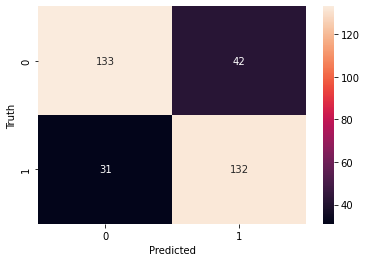

In [23]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [24]:
dft=pd.read_csv("project_test.csv")
dft

,Label1,Comments1
0,0,Our driver never showed up and Uber cancelled ...
1,1,"My driver, Rohan was nice, but when I tried to..."
2,1,Uber is overcharging for Toll fees. When In Fl...
3,0,I called uber for going home two days ago and ...
4,1,"Ordering a ride, then putting your 10, 12, and..."


In [25]:
dft_comments=dft.Comments1
dft_comments

0    Our driver never showed up and Uber cancelled ...
1    My driver, Rohan was nice, but when I tried to...
2    Uber is overcharging for Toll fees. When In Fl...
3    I called uber for going home two days ago and ...
4    Ordering a ride, then putting your 10, 12, and...
Name: Comments1, dtype: object

In [26]:
X_train_tokenized = tokenizer(list(dft_comments), padding=True, truncation=True, max_length=512)

In [27]:
validation_dataset = Dataset(X_train_tokenized)

In [28]:
raw_val, _, _ = trainer.predict(validation_dataset)
raw_val

array([[ 3.4460578, -3.352579 ],
       [-4.192773 ,  4.2383695],
       [-4.1194825,  4.271648 ],
       [ 3.878724 , -3.8687074],
       [ 1.5320139, -1.4428296]], dtype=float32)

In [29]:
val_pred= np.argmax(raw_val, axis=1)
val_pred

array([0, 1, 1, 0, 0])

In [30]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(val_pred, dft.Label1) 
accuracy

0.8

In [31]:
for i in range(0,5):
  print(dft_comments[i])
  if (val_pred[i] ==0):
    print("Review - Fair(related to driver)")
  else:
    print("Review - unfair(not related)")  
  print("\n")

Our driver never showed up and Uber cancelled our ride, not us. They charged us a cancellation fee for them cancelling. When I disputed it they would only credit it on future ride instead of refund back to our credit card. Why am I only getting a credit on account instead of a full refund to my credit card used?? This is not right what you have done when it was a Uber error.
Review - Fair(related to driver)


My driver, Rohan was nice, but when I tried to add tip I noticed that he had switched my $9 9am fare in French Quarter to someone else's 2pm trip in Metairie for $28.00! UBER refused to acknowledge. 5 attempts to rectify problem and received nothing but irrelevant automated replies. If you get in the car with Rohan in NOLA and he says he can't get his system to work, it's a a SCAM. Terrible customer service from UBER with zero relevant assistance after 7 days of requesting corrected bill. BEWARE.
Review - unfair(not related)


Uber is overcharging for Toll fees. When In Florida th